In [8]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Importing the dataset

df = pd.read_csv('uber.csv')

df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



Inference: The Datset consists of 7 features & 200000 samples.


In [4]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


In [9]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [10]:
#Checking number of unique rows in each feature

nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 5 categorical features.


In [11]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [12]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count


In [14]:
df1 = df3.copy()

# features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3 + (1.5 * IQR))]
    df1 = df1[df1[i] >= (Q1 - (1.5 * IQR))]
    df1 = df1.reset_index(drop=True)

# Convert boolean values to 1s and 0s
df1 = df1.astype(int)

display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, the dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, the dataset now has {} samples.'.format(df1.shape[0]))


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7,-73,40,-73,40,1681,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7,-73,40,-73,40,2454,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,12,-74,40,-73,40,5039,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5,-73,40,-73,40,1661,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,4,-73,40,-73,40,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0



Inference:
Before removal of outliers, the dataset had 199878 samples.
After removal of outliers, the dataset now has 163203 samples.


In [20]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163203, 32) (163203,) 
Training set  --->  (130562, 32) (130562,) 
Testing set   --->  (32641, 32)  (32641,)


In [21]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305620e+05,130562.0,1.305620e+05,130562.0,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,...,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05
mean,-1.691105e-14,0.0,1.924335e-14,0.0,1.096601e-16,3.570074e-17,-1.414968e-17,6.312936e-18,6.639467e-17,4.767355e-17,...,2.634018e-17,-2.019051e-17,6.530624e-19,8.032667e-17,1.088437e-17,4.070755e-17,-1.904765e-18,-5.703411e-17,1.262587e-17,4.081640e-19
std,1.000004e+00,0.0,1.000004e+00,0.0,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.514560e+00,0.0,-2.512683e+00,0.0,-1.622508e+00,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
25%,3.976839e-01,0.0,3.979809e-01,0.0,-7.628809e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
50%,3.976839e-01,0.0,3.979809e-01,0.0,-2.350789e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
75%,3.976839e-01,0.0,3.979809e-01,0.0,5.651610e-01,1.624673e+00,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
max,3.976839e-01,0.0,3.979809e-01,0.0,2.933218e+00,1.624673e+00,1.881034e+00,1.799003e+00,3.613456e+00,2.051975e+00,...,2.329905e+00,2.371387e+00,2.630507e+00,6.643075e-01,2.425547e+00,4.605646e+00,6.741425e+00,3.651694e+00,6.828835e+00,3.613323e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.0,32641.000000,32641.0,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,0.000831,0.0,-0.000351,0.0,0.003831,-0.004419,0.008474,-0.004463,0.001664,0.002463,...,-0.001824,0.000336,-0.000882,-0.005507,0.003732,-0.006578,0.000262,0.001559,0.013835,-2.767536e-03
std,0.999135,0.0,1.000386,0.0,1.001768,0.997773,1.005681,0.997227,1.002787,1.001937,...,0.998279,1.000343,0.999022,1.002313,1.003758,0.985453,1.000877,1.002644,1.045127,1.405581e-15
min,-2.514560,0.0,-2.512683,0.0,-1.622508,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
25%,0.397684,0.0,0.397981,0.0,-0.762881,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
50%,0.397684,0.0,0.397981,0.0,-0.230625,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
75%,0.397684,0.0,0.397981,0.0,0.574811,1.624673,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
max,0.397684,0.0,0.397981,0.0,2.933218,1.624673,1.881034,1.799003,3.613456,2.051975,...,2.329905,2.371387,2.630507,0.664307,2.425547,4.605646,6.741425,3.651694,6.828835,-2.767536e-03


In [25]:
Train_X_std.to_excel('training_data.xlsx')

In [27]:
Y.to_excel('training_data_y.xlsx')

                                       Correlation Matrix                                       


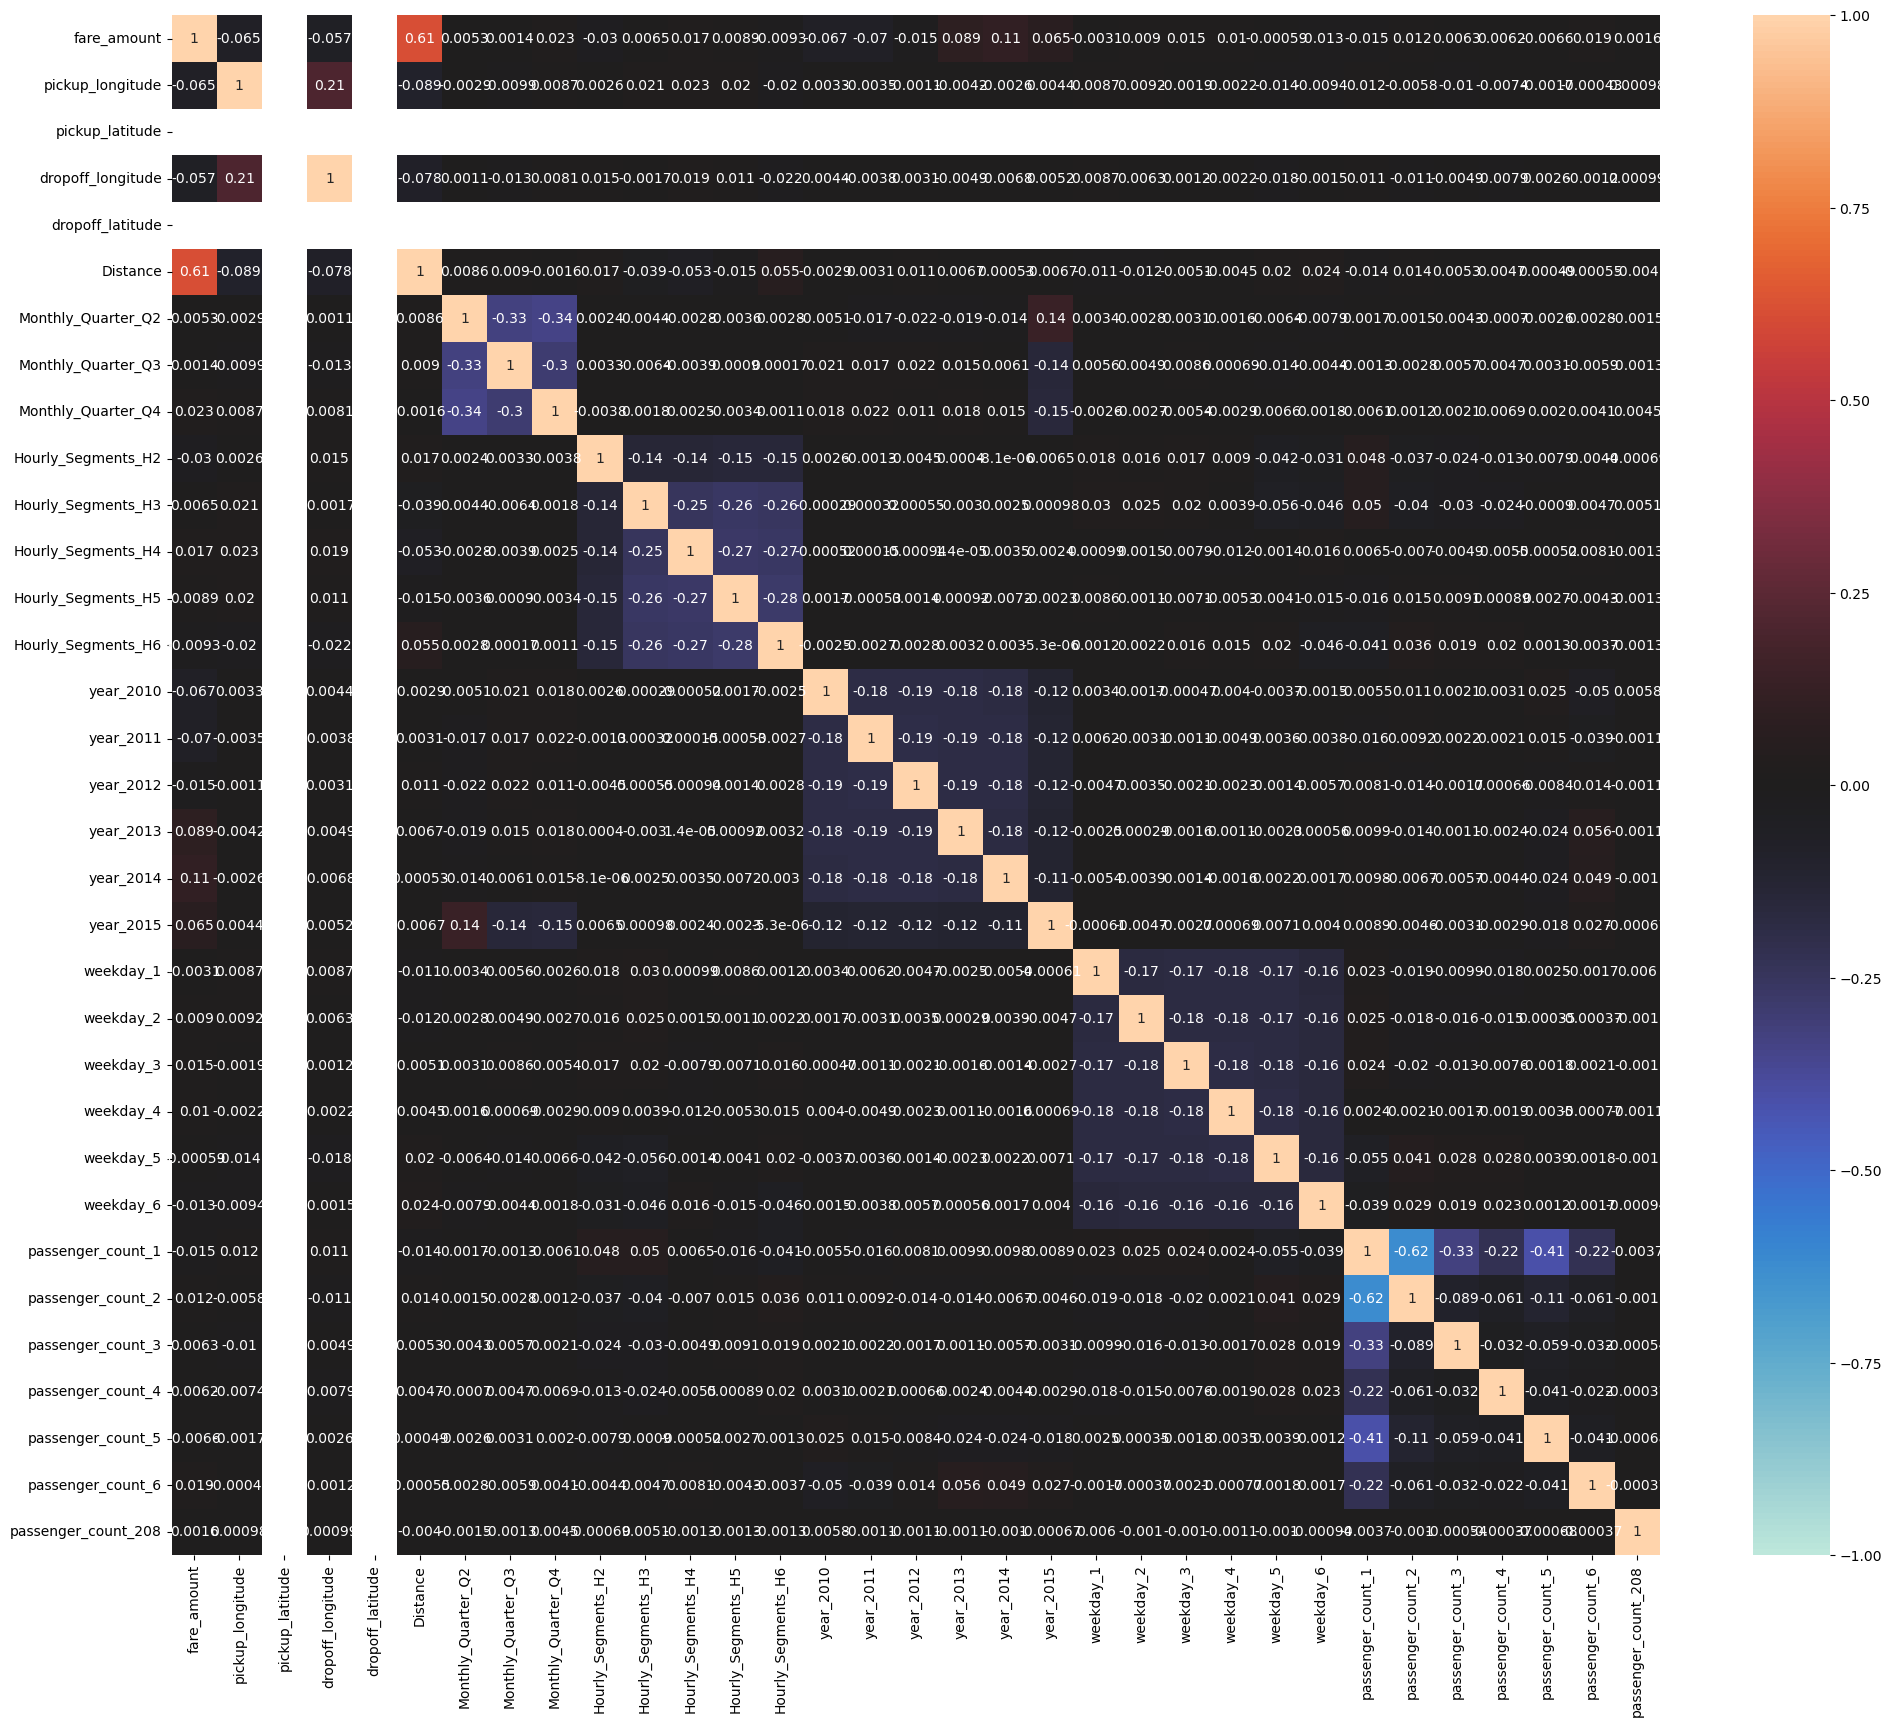

In [22]:

#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [28]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns[4:])), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     3883.
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:15:50   Log-Likelihood:            -3.3795e+05
No. Observations:              130562   AIC:                         6.760e+05
Df Residuals:                  130533   BIC:                         6.762e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.6069      0.157     10.222      0.000       1.299       1.915
Distance                0.0021   6.65e-06    313.509      0.000       0.002       0.002
Monthly_Quarter_Q2      0.1430      0.024      5.913      0.000       0.096       0.190
Monthly_Quarter_Q3      0.3419      0.026     13.124      0.000       0.291       0.393
Monthly_Quarter_Q4      0.5549      0.026     21.694      0.000       0.505       0.605
Hourly_Segments_H2     -0.3352      0.045     -7.473      0.000      -0.423      -0.247
Hourly_Segments_H3      0.6972      0.036     19.299      0.000       0.626       0.768
Hourly_Segments_H4      0.8716      0.035     24.566      0.000       0.802       0.941
Hourly_Segments_H5      0.5874      0.035     16.751      0.000       0.519       0.656
Hourly_Segments_H6      0.0289      0.035      0.821      0.411      -0.040       0.098
year_2010               0.1169      0.032      3.638      0.000       0.054       0.180
year_2011               0.0745      0.032      2.339      0.019       0.012       0.137
year_2012               0.6092      0.032     19.160      0.000       0.547       0.672
year_2013               1.7292      0.032     53.844      0.000       1.666       1.792
year_2014               1.9976      0.032     61.501      0.000       1.934       2.061
year_2015               2.1576      0.042     51.490      0.000       2.075       2.240
weekday_1               0.2434      0.034      7.065      0.000       0.176       0.311
weekday_2               0.3661      0.034     10.674      0.000       0.299       0.433
weekday_3               0.4246      0.034     12.471      0.000       0.358       0.491
weekday_4               0.3619      0.034     10.685      0.000       0.295       0.428
weekday_5               0.0755      0.034      2.199      0.028       0.008       0.143
weekday_6              -0.1590      0.036     -4.418      0.000      -0.229      -0.088
passenger_count_1       0.2401      0.150      1.604      0.109      -0.053       0.534
passenger_count_2       0.3989      0.151      2.638      0.008       0.103       0.695
passenger_count_3       0.4236      0.155      2.729      0.006       0.119       0.728
passenger_count_4       0.5077      0.161      3.147      0.002       0.192       0.824
passenger_count_5       0.3454      0.153      2.256      0.024       0.045       0.645
passenger_count_6       0.2710      0.162      1.675      0.094      -0.046       0.588
passenger_count_208     7.7619      3.224      2.407      0.016       1.442      14.082
==============================================================================
Omnibus:                   202663.549   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        295519917.631
Skew:                         